In [1]:
# always essential 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# image processing
from PIL import Image, ImageOps
from keras.preprocessing.image import ImageDataGenerator
#import imgaug as ia
#from imgaug import augmenters as iaa

# label encoding 
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing

# CNN model
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import  Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
import resnet
import tensorflow as tf

# system/util
import glob
import os
from collections import Counter

%matplotlib inline

Using TensorFlow backend.


## Load Images

In [2]:
images = []
files = []
names = []
for filename in glob.glob('input/images-train/*/*.jpg'): 
    im=Image.open(filename)
    images.append(np.array(im))
    files.append(filename)
    names.append(filename.split('/')[2])
    im.close()
    
files = np.array(files)
names = np.array(names)

## Load tests

In [3]:
tests = []
test_files = []
for filename in glob.glob('input/images-val-pub/*.jpg'): 
    im=Image.open(filename)
    test_files.append(filename)
    tests.append(np.array(im))
    im.close()
test_files = np.array(test_files)

### Statistics

Total files: 5211
Total celeberties: 98


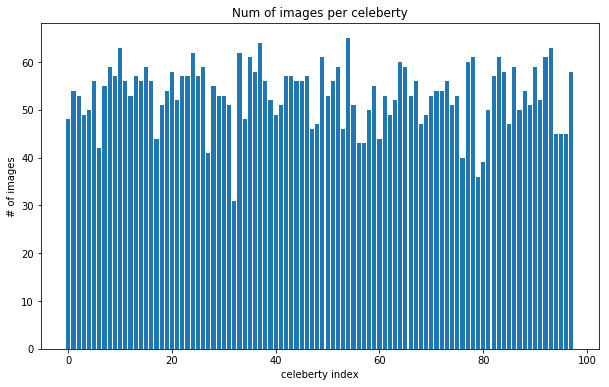

In [7]:
count = Counter(names)
print(f'Total files: {len(files)}')
print(f'Total celeberties: {len(count)}')

plt.figure(figsize=(10, 6))

plt.bar(range(len(count)), list(count.values())[::-1], align='center')
plt.title("Num of images per celeberty")
plt.xlabel('celeberty index')
plt.ylabel('# of images')

plt.show()

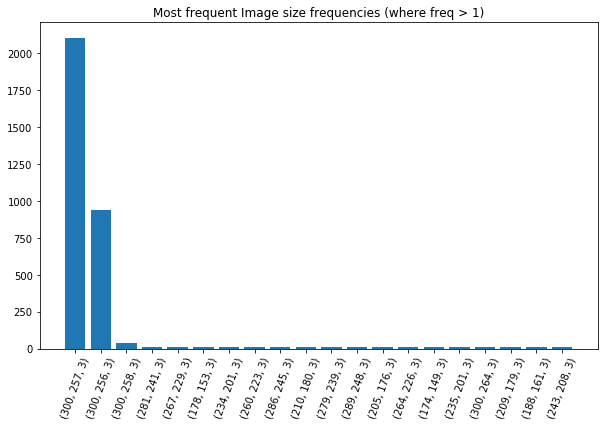

In [8]:
img_sizes = Counter([i.shape for i in images])

size, freq = zip(*Counter({i: v for i, v in img_sizes.items() if v > 1}).most_common(20))

plt.figure(figsize=(10, 6))

plt.bar(range(len(freq)), list(freq), align='center')
plt.xticks(range(len(size)), list(size), rotation=70)
plt.title("Most frequent Image size frequencies (where freq > 1)")

plt.show()

### Look at a sample

adam_levine


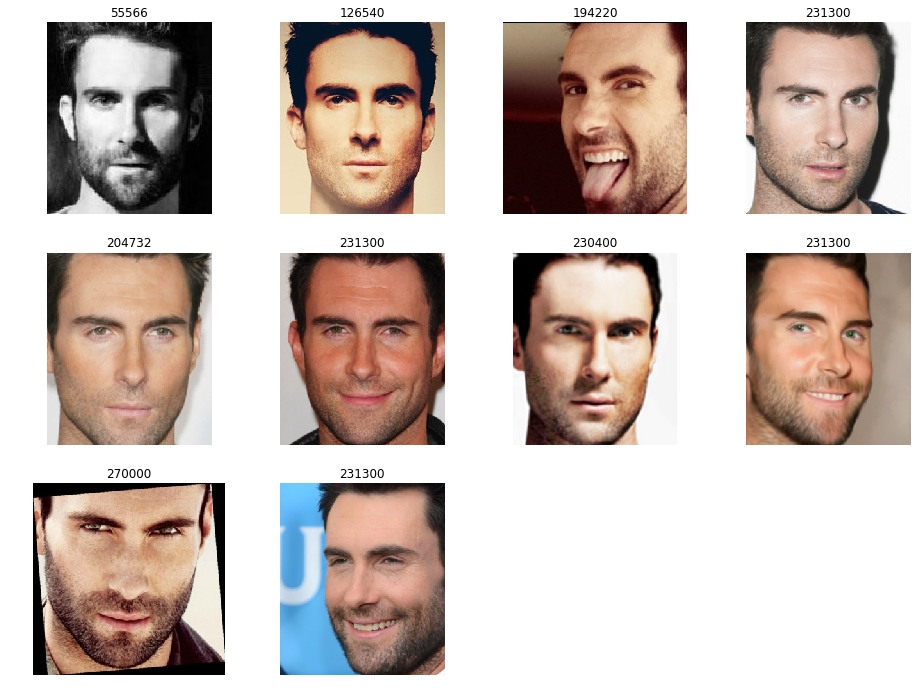

In [9]:
figure = plt.figure(figsize=(16, 12))

rows = 3
cols = 4
cols = len(images[:10]) // rows +1

for i in range(len(images[:10])):
    subplot = figure.add_subplot(rows, cols, i+1)
    subplot.axis('Off')
    subplot.set_title(images[i].shape, fontsize=12)
    plt.imshow(images[i], cmap='gray')
print(names[9])

## Processing

### Pad to same size

In [4]:
def pad2sqr(img, desired_size = 224):
    im = Image.fromarray(img)
    old_size = im.size  # old_size[0] is in (width, height) format
    ratio = float(desired_size)/max(old_size)
    
    new_size = tuple([int(x*ratio) for x in old_size])
    # use thumbnail() or resize() method to resize the input image
    # thumbnail is a in-place operation
    # im.thumbnail(new_size, Image.ANTIALIAS)

    im = im.resize(new_size, Image.ANTIALIAS)
    # create a new image and paste the resized on it

    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(im, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))

    return np.array(new_im)

In [5]:
for i in range(len(images)):
    padded = pad2sqr(images[i], 224)
    images[i] = padded
images = np.stack(images)
print(images.shape)

(5211, 224, 224, 3)


In [6]:
for i in range(len(tests)):
    padded = pad2sqr(tests[i], 224)
    tests[i] = padded
tests = np.stack(tests)
print(tests.shape)

(2628, 224, 224, 3)


### Look at the result

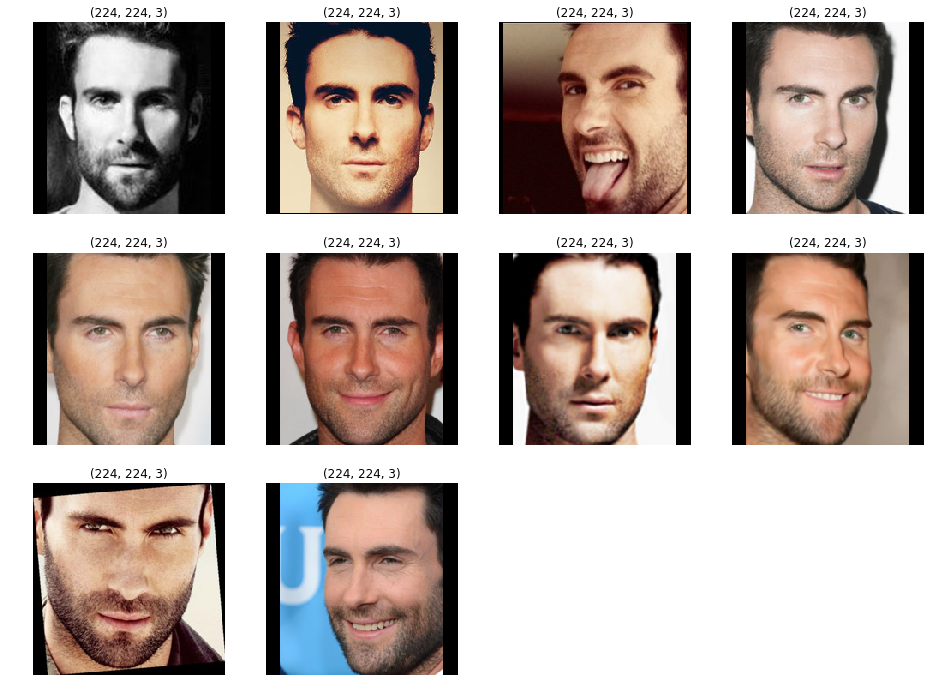

In [7]:
figure = plt.figure(figsize=(16, 12))

rows = 3
cols = 4
cols = len(images[:10]) // rows +1

for i in range(len(images[:10])):
    subplot = figure.add_subplot(rows, cols, i+1)
    subplot.axis('Off')
    subplot.set_title(images[i].shape, fontsize=12)
    plt.imshow(images[i], cmap='gray')


### Label encoding

In [15]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
le = preprocessing.LabelEncoder()
le.fit(names)
encoded_names = to_categorical(le.transform(names), num_classes = 98)

### Save numpy array

In [9]:
np.save('./input/X_train_224.npy', images)
#np.save('./input/names.npy', np.array(list(le.classes_)))
#np.save('./input/Y_train_224.npy', encoded_names)
np.save('./input/X_test_224.npy', tests)
#np.save('./input/test_files.npy', test_files)

# **All code below are for demo & learning purpose**

- The below code uses 10% of the original input data for faster execution.
- For actual submission, please use the `minimal` version, load in the numpy arrays save above and tune your parameters.
- I suggest using Kaggle Kernel and utilizing their GPU option to speed up

### Augmentation + Normalization + Split

#### Visualizing augmentation on a small sample

In [35]:
sample_images = images[::10]
sample_names = encoded_names[::10]

In [36]:
sample_gen = ImageDataGenerator(
         rotation_range=10,
        width_shift_range=0.15,
        height_shift_range=0.15,
        brightness_range=(0.8,1.2),
        shear_range=0.2,
        zoom_range=0.1,
        channel_shift_range=0.2,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format="channels_last"
)
sample_gen.fit(sample_images)


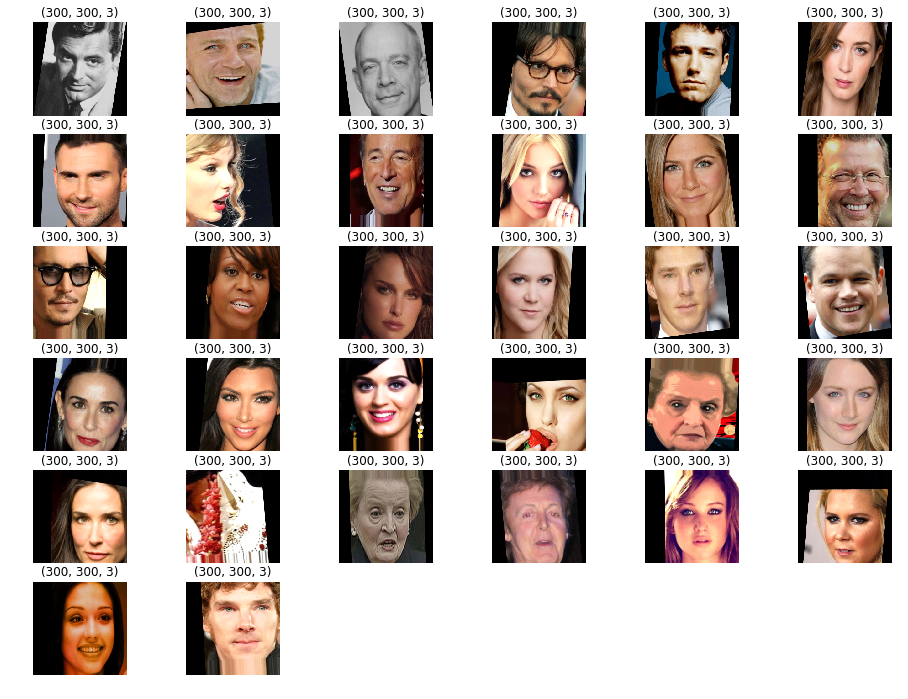

In [37]:
# I dont completely understand how flow() works yet, based on my experiement it loops forever
for batch in sample_gen.flow(sample_images,sample_names):
    figure = plt.figure(figsize=(16, 12))

    rows = 6
    cols = 6
    cols = len(batch[0]) // rows +1

    for i in range(len(batch[0])):
        subplot = figure.add_subplot(rows, cols, i+1)
        subplot.axis('Off')
        subplot.set_title(batch[0][i].shape, fontsize=12)
        plt.imshow(batch[0][i].astype(np.uint8),cmap='gray')
    break

#### all combined on whole dataset

In [38]:
datagen = ImageDataGenerator(
        rotation_range=0.1,
        width_shift_range=0.15,
        height_shift_range=0.15,
        brightness_range=(0.8,1.2),
        shear_range=0.2,
        zoom_range=0.1,
        channel_shift_range=0.1,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format="channels_last",

        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=True,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
    
        validation_split=0.2
)

datagen.fit(sample_images)

## CNN model (ResNet-152)

### Hyper parameters

In [39]:
epochs = 2
batch_size = 32

# \*\*\* This model is too complex for my laptop

below code wasn't tested

In [1]:
model = resnet.ResNet152(weights=None,input_shape=(300,300,3),classes=98)
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

NameError: name 'resnet' is not defined

In [ ]:
history = model.fit_generator(generator=datagen.flow(sample_images, sample_names, subset = "training"),
                              validation_data = datagen.flow(sample_images, sample_names, subset = "validation"),
                              epochs = epochs, 
                              verbose = 2, 
                              steps_per_epoch=sample_images.shape[0] // batch_size
                              )

Epoch 1/2


## Evaluate the model
### Training and validation curves

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

### most important errors

In [ ]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

# Submission

In [ ]:
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)
result_names = [names[i] for i in results]

result_names = pd.Series(results,name="celebrity_name")
submission = pd.concat([pd.Series(test_names,name = "image_label"),result_names],axis = 1)

submission.to_csv("celeberty_resnet_152.csv",index=False)